In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.375.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.704.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.8597.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.5740.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.5703.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.7717.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.2618.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.1956.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.5608.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.5646.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.7267.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.5341.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.7792.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.2888.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.3808.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.838

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPooling2D,Dropout,RandomFlip,RandomRotation,RandomTranslation,RandomZoom,Flatten,RandomContrast
from tensorflow.keras.activations import relu,sigmoid

2025-07-21 15:34:03.195632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753112043.401410      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753112043.469167      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BASE_DIR='/kaggle/input/dogs-vs-cats'
train_dir=os.path.join(BASE_DIR,'/kaggle/input/dogs-vs-cats/train')
validation_dir=os.path.join(BASE_DIR,'/kaggle/input/dogs-vs-cats/test')

train_cats_dir=os.path.join(train_dir,'cats')
train_dogs_dir=os.path.join(train_dir,'dogs')

validation_cats_dir=os.path.join(validation_dir,'cats')
validation_dogs_dir=os.path.join(validation_dir,'dogs')

train_cats_fnames=os.listdir(train_cats_dir)
train_dogs_fnames=os.listdir(train_dogs_dir)
validation_cats_fnames=os.listdir(validation_cats_dir)
validation_dogs_fnames=os.listdir(validation_dogs_dir)

print(len(train_cats_fnames),len(train_dogs_fnames),len(validation_cats_fnames),len(validation_dogs_fnames))

10000 10000 2500 2500


In [4]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150,150),
    batch_size=20,
    label_mode='binary'
)

validation_dataset=tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(150,150),
    batch_size=20,
    label_mode='binary'
)

Found 20000 files belonging to 2 classes.


I0000 00:00:1753112062.626189      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 5000 files belonging to 2 classes.


In [5]:
!wget https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2025-07-21 15:34:26--  https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 74.125.142.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/octet-stream]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   212MB/s    in 0.4s    

2025-07-21 15:34:26 (212 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
local_weights_file='./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model=tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(150,150,3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable=False

In [7]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [8]:
last_layer=pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output=last_layer.output


last layer output shape:  (None, 7, 7, 768)


In [9]:
x=Flatten()(last_output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model=Model(pre_trained_model.input,x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [10]:
def preprocess(image,label):
    image=tf.keras.applications.inception_v3.preprocess_input(image)
    return image,label

train_dataset_scaled=train_dataset.map(preprocess)
validation_dataset_scaled=validation_dataset.map(preprocess)

In [11]:
SHUFFLE_BUFFER_SIZE=1000
PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE

train_dataset_final=(train_dataset_scaled.cache()
                    .shuffle(SHUFFLE_BUFFER_SIZE)
                    .prefetch(PREFETCH_BUFFER_SIZE))

validation_dataset_final=(validation_dataset_scaled.cache()
                         .prefetch(PREFETCH_BUFFER_SIZE))

In [12]:
data_augmentation=Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.4),
    RandomTranslation(0.2,0.2),
    RandomContrast(0.4),
    RandomZoom(0.2)
    
])

In [13]:
inputs=Input(shape=(150,150,3))
x=data_augmentation(inputs)
x=model(x)

model_with_aug=Model(inputs,x)

In [14]:
model_with_aug.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

In [15]:
EPOCHS = 20

# Train the model.
history = model_with_aug.fit(
    train_dataset_final,
    validation_data = validation_dataset_final,
    epochs = EPOCHS,
    verbose = 2)

Epoch 1/20


I0000 00:00:1753112120.502940      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


1000/1000 - 92s - 92ms/step - accuracy: 0.7527 - loss: 0.4981 - val_accuracy: 0.9560 - val_loss: 0.1092
Epoch 2/20
1000/1000 - 36s - 36ms/step - accuracy: 0.7902 - loss: 0.4393 - val_accuracy: 0.9602 - val_loss: 0.1073
Epoch 3/20
1000/1000 - 36s - 36ms/step - accuracy: 0.7971 - loss: 0.4262 - val_accuracy: 0.9414 - val_loss: 0.1749
Epoch 4/20
1000/1000 - 36s - 36ms/step - accuracy: 0.8036 - loss: 0.4137 - val_accuracy: 0.9502 - val_loss: 0.1366
Epoch 5/20
1000/1000 - 36s - 36ms/step - accuracy: 0.8117 - loss: 0.4058 - val_accuracy: 0.9448 - val_loss: 0.1678
Epoch 6/20
1000/1000 - 35s - 35ms/step - accuracy: 0.8119 - loss: 0.4005 - val_accuracy: 0.9578 - val_loss: 0.1325
Epoch 7/20
1000/1000 - 33s - 33ms/step - accuracy: 0.8166 - loss: 0.3997 - val_accuracy: 0.9632 - val_loss: 0.1123
Epoch 8/20
1000/1000 - 33s - 33ms/step - accuracy: 0.8170 - loss: 0.3935 - val_accuracy: 0.9536 - val_loss: 0.1455
Epoch 9/20
1000/1000 - 35s - 35ms/step - accuracy: 0.8212 - loss: 0.3878 - val_accuracy: 0.

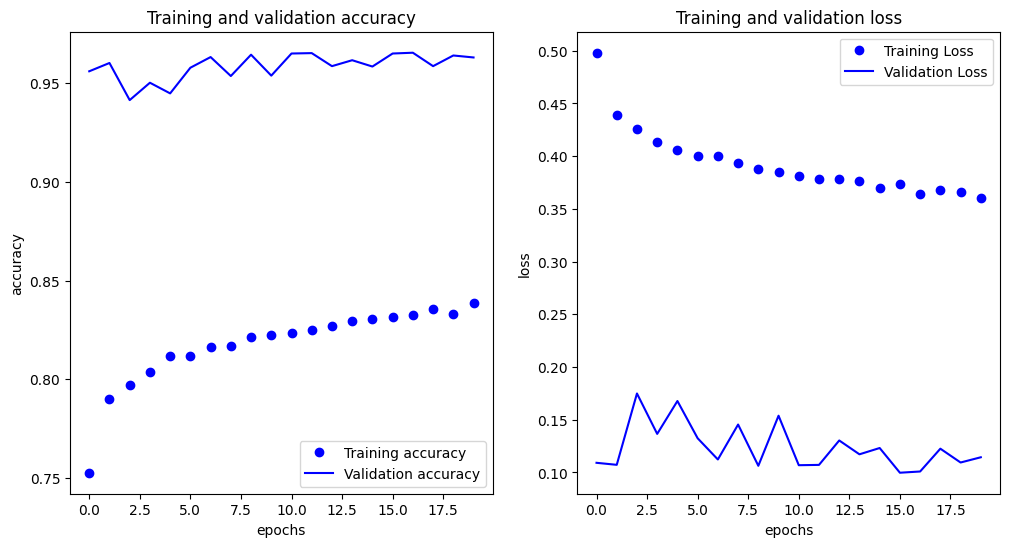

In [16]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)